In [157]:
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [158]:

# indelphi sample
# >2_1_4_2_GTGTCGCCGGTCTACATTAC 30 FORWARD
# ATCGCTGAGCGTGTCGCCGGTCTACATTACAGGCTTCCCCCTGGGCTCGTAGCGC
def get_sequence_with_flank_lengths(sequence, pam_index, left_flank_len, right_flank_len, include_spacer=False):
    l = sequence[pam_index-left_flank_len:pam_index]
    r = sequence[pam_index:pam_index+right_flank_len]
    if include_spacer:
        return l + "|" + r
    else: 
        return l + r
sequence = "ATCGCTGAGCGTGTCGCCGGTCTACATTACAGGCTTCCCCCTGGGCTCGTAGCGC"
pam_index = 30
left_flank_len = 30
right_flank_len = 25
# print(f"Starting sequence: {sequence}")
after = get_sequence_with_flank_lengths(sequence, pam_index, left_flank_len, right_flank_len, include_spacer=True)
print(f"After sequence: {after}")

# FORECasT sample
# >Oligo_43170 42 FORWARD
# CTCCTATAATTCTAATCACTACAAGTCAGGAATGCCTGCGTTTGGCCGTCCAGTTAGTAACAGAAGGTCAGGTAAGAGG
sequence = "CTCCTATAATTCTAATCACTACAAGTCAGGAATGCCTGCGTTTGGCCGTCCAGTTAGTAACAGAAGGTCAGGTAAGAGG"
pam_index = 42
# print(f"Starting sequence: {sequence}")
after = get_sequence_with_flank_lengths(sequence, pam_index, left_flank_len, right_flank_len, include_spacer=True)
print(f"After sequence: {after}")





After sequence: ATCGCTGAGCGTGTCGCCGGTCTACATTAC|AGGCTTCCCCCTGGGCTCGTAGCGC
After sequence: TAATCACTACAAGTCAGGAATGCCTGCGTT|TGGCCGTCCAGTTAGTAACAGAAGG


In [159]:
from src.analysis.calculate_homology import read_fasta, align_score

FORECAST_train_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/train.fasta'
FORECAST_test_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/train.fasta'
FC_sequences = read_fasta(FORECAST_train_file_path) + read_fasta(FORECAST_test_file_path)

print(f"Number of FORECasT Sequences: {len(FC_sequences)}")

Number of FORECasT Sequences: 13268


In [160]:
indelphi_test_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/inDelphi/train.fasta'
indelphi_train_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/inDelphi/test.fasta'
indelphi_sequences = read_fasta(indelphi_train_file_path) + read_fasta(indelphi_test_file_path)

print(f"Number of Indelphi Sequences: {len(indelphi_sequences)}")

Number of Indelphi Sequences: 1993


In [161]:
indelphi_sequences[0]

('2_1_4_2_GTGTCGCCGGTCTACATTAC',
 'GTCATATCGCTGAGCGTGTCGCCGGTCTACATTACAGGCTTCCCCCTGGGCTCGTAGCGC')

In [162]:
# aligner = "global"
aligner = "local"
# aligner = "edit"

if aligner == "global":
    plot_text = "Smith-Waterman"
if aligner == "local":
    plot_text = "Needleman-Wunsch"
if aligner == "edit":
    plot_text = "Hamming Distance"


In [163]:
max_sw_score = align_score(indelphi_sequences[0][1], indelphi_sequences[0][1], mode=aligner)
print(f"Max {plot_text} Score is {max_sw_score}")

Max Needleman-Wunsch Score is 60.0


In [164]:
import pandas as pd


align_df = pd.read_csv(f"/Users/colm/repos/x-crisp/data/processed/alignment_{aligner}.tsv", sep="\t")
align_df = align_df.set_index("Target2")

In [165]:
# hack
align_df = align_df.drop('4_4_2_0_GCTTGGCTGTCTAATTATTT', axis=1)

In [166]:
target_ids = align_df.columns
FC_ids = [t for t in target_ids if "Oligo" in t]
indelphi_ids = [t for t in target_ids if "Oligo" not in t]

In [167]:
FC_alignment_scores = align_df[FC_ids].loc[FC_ids]
indelphi_alignment_scores = align_df[indelphi_ids]
cross_alignment_scores = align_df[indelphi_ids].loc[FC_ids]

Target2                 
Oligo_33090  Oligo_49283    37.0
             Oligo_26698    37.0
             Oligo_12523    36.0
             Oligo_6571     36.0
             Oligo_47864    39.0
dtype: float64
(61123096,)


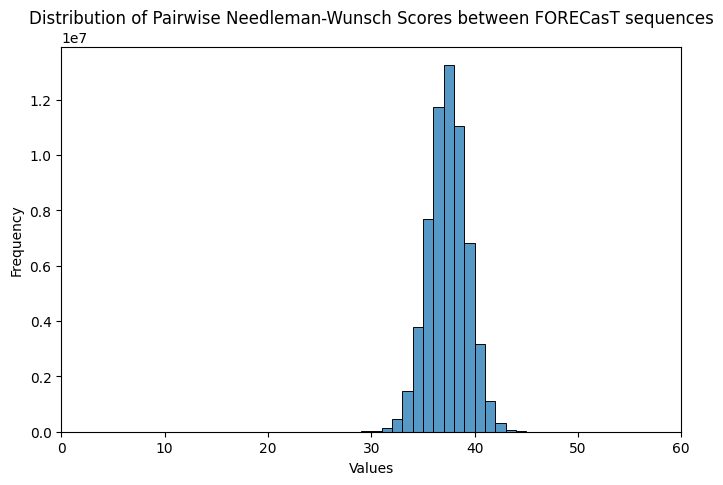

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
# Mask to get only the upper triangle (excluding the diagonal if desired)
import numpy as np
upper_triangle_values_1 = FC_alignment_scores.where(np.triu(np.ones(FC_alignment_scores.shape), k=1).astype(bool)).stack()
print(upper_triangle_values_1.head())
print(upper_triangle_values_1.shape)

# Define the bin range and bin width (0 to 55 with bins of width 5)
bin_range = (0, 60)
bin_width = 1
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)

# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values_1, bins=bins, kde=False)
plt.title(f'Distribution of Pairwise {plot_text} Scores between FORECasT sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig(f"./artifacts/pairwise-{plot_text}-forecast.pdf",  bbox_inches='tight')


Target2                                                   
2_4_2_2_CTTTCACAAGTAAGTATTCG  1_4_0_2_CTATGCCATTAAAAAAATTC    41.0
4_0_4_1_GCGTGGCTAACGCGGGGTAT  2_4_2_2_CTTTCACAAGTAAGTATTCG    39.0
                              1_4_0_2_CTATGCCATTAAAAAAATTC    35.0
0_4_4_2_GTCCTCCTGATACATTCGTT  4_0_4_1_GCGTGGCTAACGCGGGGTAT    38.0
                              2_4_2_2_CTTTCACAAGTAAGTATTCG    39.0
dtype: float64
(991020,)


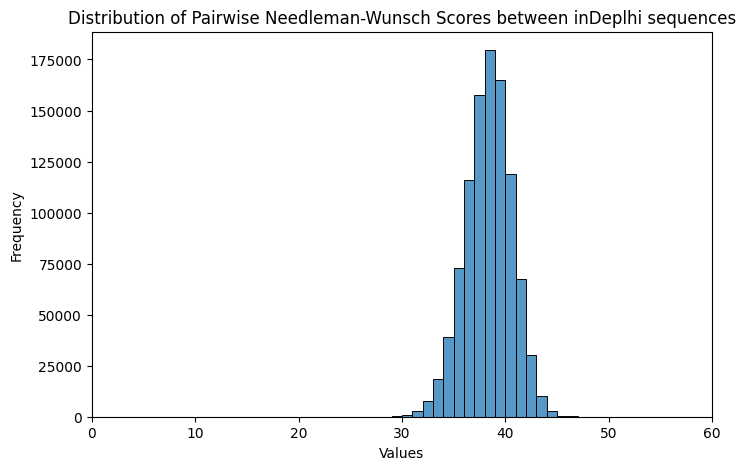

In [169]:
upper_triangle_values_2 = indelphi_alignment_scores.where(np.triu(np.ones(indelphi_alignment_scores.shape), k=1).astype(bool)).stack()
print(upper_triangle_values_2.head())
print(upper_triangle_values_2.shape)


# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values_2, bins=bins, kde=False)
plt.title(f'Distribution of Pairwise {plot_text} Scores between inDeplhi sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig(f"./artifacts/pairwise-{plot_text}-indelphi.pdf",  bbox_inches='tight')


Target2                                  
Oligo_33090  0_3_1_1_TCACGACCATTCCTGATTAG    38.0
             2_2_4_2_ACGGTCCCTGTTCCAGCGTT    38.0
             1_2_3_3_TGCATTCTGAGTCAGGACCC    36.0
             0_3_2_3_TGATCCCCCACAATGTTGGG    36.0
             2_2_0_4_TTACCACTAAACATTGCAGC    37.0
dtype: float64
(1983036,)


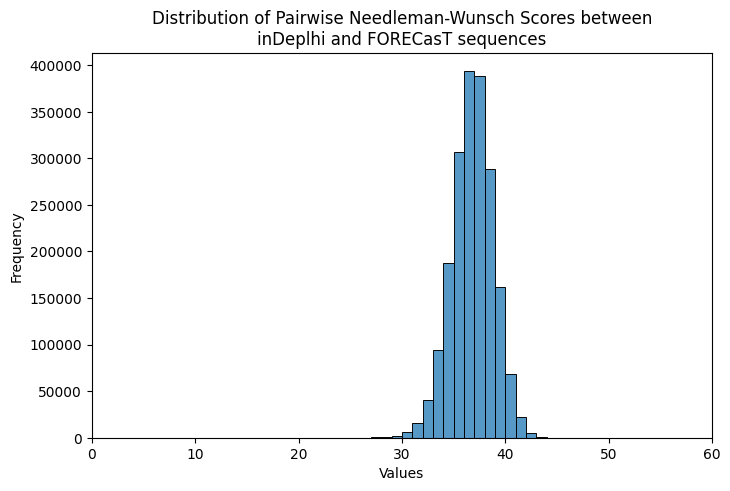

In [170]:
upper_triangle_values_3 = cross_alignment_scores.where(np.triu(np.ones(cross_alignment_scores.shape), k=1).astype(bool)).stack()
print(upper_triangle_values_3.head())
print(upper_triangle_values_3.shape)

# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values_3, bins=bins, kde=False)
plt.title(f'Distribution of Pairwise {plot_text} Scores between\ninDeplhi and FORECasT sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig(f"./artifacts/pairwise-{plot_text}-pairwise.pdf",  bbox_inches='tight')

In [171]:
FORECAST_train_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/train.fasta'
FORECAST_test_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/test.fasta'
FC_train = read_fasta(FORECAST_train_file_path) 
FC_test = read_fasta(FORECAST_test_file_path)

print(f"Number of FORECasT Sequences: {len(FC_train)}")
print(f"Number of FORECasT Sequences: {len(FC_test)}")

Number of FORECasT Sequences: 6634
Number of FORECasT Sequences: 4424


In [172]:
indelphi_train_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/inDelphi/test.fasta'
indelphi_test = read_fasta(indelphi_test_file_path)

print(f"Number of Indelphi Sequences: {len(indelphi_test)}")

Number of Indelphi Sequences: 1593


In [173]:
FC_train = [f[0] for f in FC_train]
FC_test = [f[0] for f in FC_test]
indelphi_test = [i[0] for i in indelphi_test]

Target2                 
Oligo_10007  Oligo_10012    38.0
             Oligo_10018    37.0
             Oligo_1002     35.0
             Oligo_1003     36.0
             Oligo_10048    39.0
dtype: float64
(29342182,)


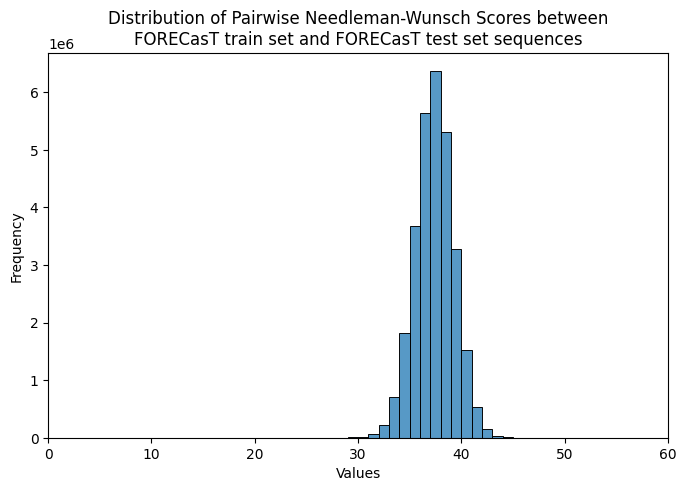

In [174]:
upper_triangle_values_4 = FC_alignment_scores.loc[np.intersect1d(FC_test, FC_alignment_scores.columns.to_list()), np.intersect1d(FC_train, FC_alignment_scores.index.to_list())].stack()
print(upper_triangle_values_4.head())
print(upper_triangle_values_4.shape)

# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values_4, bins=bins, kde=False)
plt.title(f'Distribution of Pairwise {plot_text} Scores between\nFORECasT train set and FORECasT test set sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig(f"./artifacts/pairwise-{plot_text}-FC-train-FC-test.pdf",  bbox_inches='tight')

Target2                                  
Oligo_10012  0_0_0_0_AAATATCTTTAACCTAAAAC    35.0
             0_0_0_0_AATCCTCTAAATAGTTAAAT    37.0
             0_0_0_0_CTTTCACTTTATAGATTTAT    34.0
             0_0_0_1_TCTTATCTTGCAAGGCTTCA    35.0
             0_0_0_1_TGTCATCTTTATGCTTAAAG    37.0
dtype: float64
(10561328,)


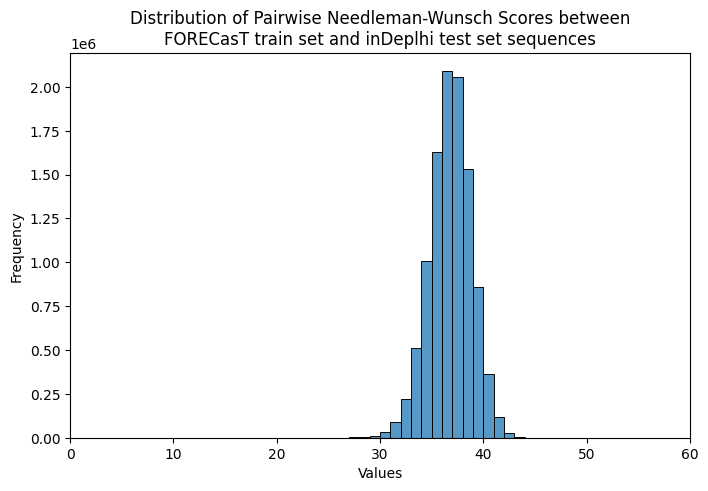

In [175]:
upper_triangle_values_5 = cross_alignment_scores.loc[np.intersect1d(FC_train, cross_alignment_scores.index.to_list()), np.intersect1d(indelphi_test, cross_alignment_scores.columns.to_list())].stack()
print(upper_triangle_values_5.head())
print(upper_triangle_values_5.shape)

# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values_5, bins=bins, kde=False)
plt.title(f'Distribution of Pairwise {plot_text} Scores between\nFORECasT train set and inDeplhi test set sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig(f"./artifacts/pairwise-{plot_text}-FC-train-indelphi-test.pdf",  bbox_inches='tight')

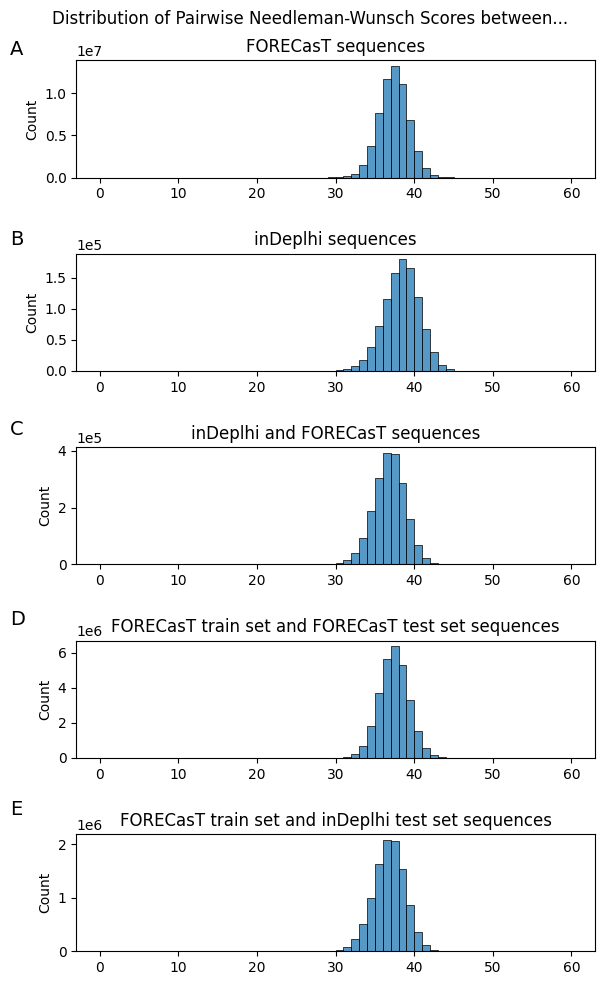

In [176]:
fig, axes = plt.subplots(5, 1, figsize=(6, 10))

fig.suptitle(f"Distribution of Pairwise {plot_text} Scores between...")

axes[0].set_title("FORECasT sequences")
sns.histplot(upper_triangle_values_1, bins=bins, kde=False, ax=axes[0])

axes[1].set_title("inDeplhi sequences")
sns.histplot(upper_triangle_values_2, bins=bins, kde=False, ax=axes[1])

axes[2].set_title("inDeplhi and FORECasT sequences")
sns.histplot(upper_triangle_values_3, bins=bins, kde=False, ax=axes[2])

axes[3].set_title("FORECasT train set and FORECasT test set sequences")
sns.histplot(upper_triangle_values_4, bins=bins, kde=False, ax=axes[3])

axes[4].set_title("FORECasT train set and inDeplhi test set sequences")
sns.histplot(upper_triangle_values_5, bins=bins, kde=False, ax=axes[4])

labels = ["A", "B", "C", "D", "E"]

fig.text(0.0, 0.19, "E", fontsize=14, va="top", ha="left")
fig.text(0.0, 0.38, "D", fontsize=14, va="top", ha="left")
fig.text(0.0, 0.57, "C", fontsize=14, va="top", ha="left")
fig.text(0.0, 0.76, "B", fontsize=14, va="top", ha="left")
fig.text(0.0, 0.95, "A", fontsize=14, va="top", ha="left")

for ax in axes:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 

plt.tight_layout()
plt.savefig(f"./artifacts/pairwise-{plot_text}.pdf",  bbox_inches='tight')

In [177]:
def read_sequence_ids(dataset="inDelphi", t="test"):
    my_path = f'/Users/colm/repos/repair-outcome-prediction/local/data/{dataset}/{t}.fasta'
    my = read_fasta(my_path)
    my = [i[0] for i in my]
    print(len(my))
    return my

indelphi_test = read_sequence_ids(dataset="inDelphi", t="test")
indelphi_train = read_sequence_ids(dataset="inDelphi", t="train")
indelphi_transfertest = read_sequence_ids(dataset="inDelphi", t="transfertest")
indelphi_transfertrain = read_sequence_ids(dataset="inDelphi", t="transfertrain")

forecast_test = read_sequence_ids(dataset="FORECasT", t="test")
forecast_train = read_sequence_ids(dataset="FORECasT", t="train")

400
1593
1000
996
4424
6634


In [178]:
def overlap(arr1, arr2):
    print(np.intersect1d(arr1, arr2).shape[0])

overlap(indelphi_test, indelphi_train)
overlap(indelphi_test, indelphi_transfertest)
overlap(indelphi_test, indelphi_transfertrain)

overlap(indelphi_train, indelphi_transfertrain)

overlap(indelphi_transfertest, indelphi_transfertrain)



0
400
0
994
0
